In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandasql import sqldf
from datetime import date
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import both "Trans_Sem" files
df1 = pd.read_csv('Trans_Sem.txt', sep='§', encoding='unicode_escape', engine='python')
df2 = pd.read_csv('Trans_2_Sem.txt', sep='§', encoding='unicode_escape', engine='python')

#Join both in the same dataframe
df = pd.concat([df1, df2], axis=0, ignore_index=True)

display(df)

,Placa,IdCliente,IdEstacion,ValorVenta,Gal_Fid,Gal,FechaVenta
0,WOX691,-99999,1173,10627.0,0.00,7.09,2017-07-24 00:00:00
1,WGB712,710007,1205,8836.0,3.58,6.55,2017-07-24 00:00:00
2,SXE315,564092,1201,3942.0,2.32,2.32,2017-07-24 00:00:00
3,WTP494,736117,2000,6264.0,3.82,3.82,2017-07-24 00:00:00
4,WTQ127,1781207,2000,12726.0,7.76,7.76,2017-07-24 00:00:00
...,...,...,...,...,...,...,...
739676,STN614,1745417,1133,7736.0,5.53,5.53,2017-07-30 00:00:00
739677,VEJ529,1965410,1560,10884.0,7.78,7.78,2017-07-30 00:00:00
739678,VFD811,-99999,1276,10042.0,0.00,6.09,2017-07-30 00:00:00
739679,TMF885,-99999,1298,15000.0,0.00,10.75,2017-07-30 00:00:00


In [3]:
# Now for some cleaning
# Remove duplicate rows
df.drop_duplicates()
# Trim leading and trailing spaces
df['Placa'].str.strip()
# Check datatypes 
df.dtypes
# Parse datatypes
df['FechaVenta'] = pd.to_datetime(df['FechaVenta']).dt.date
df['FechaVenta']  
# Check for missing values
df.info() # No missing values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739681 entries, 0 to 739680
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Placa       739681 non-null  object 
 1   IdCliente   739681 non-null  int64  
 2   IdEstacion  739681 non-null  int64  
 3   ValorVenta  739681 non-null  float64
 4   Gal_Fid     739681 non-null  float64
 5   Gal         739681 non-null  float64
 6   FechaVenta  739681 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 39.5+ MB


In [4]:
# Now some exploratory analysis, which helps with cleaning as well
df.describe()

,IdCliente,IdEstacion,ValorVenta,Gal_Fid,Gal
count,7.396810e+05,739681.000000,739681.000000,739681.000000,739681.000000
mean,1.077209e+06,1449.322891,11118.548181,6.077338,7.386308
std,7.666982e+05,309.994832,6398.603262,4.776967,4.097792
min,-9.999900e+04,1107.000000,1.000000,0.000000,0.000000
25%,5.694580e+05,1211.000000,7490.000000,3.630000,5.260000
50%,8.348720e+05,1303.000000,10000.000000,6.060000,6.630000
75%,1.821454e+06,1718.000000,12757.000000,7.760000,8.210000
max,1.977199e+06,2201.000000,263215.000000,168.130000,168.130000


Como podemos ver, el rango intercuantil de la variable Gal es pequeño, de casi 3. Sin embargo, hay outliers, y varios, como se puede ver en el siguiente gráfico.

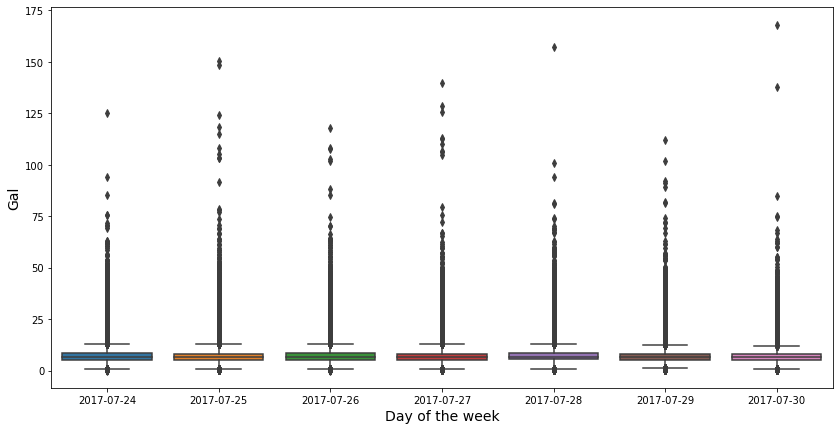

In [5]:
fig= plt.figure(figsize=(14,7))
sns.boxplot(data=df, x='FechaVenta', y='Gal')
plt.xlabel('Day of the week', fontsize=14)
plt.ylabel('Gal', fontsize=14)

plt.savefig('boxPlot_gal.jpg')
plt.show()

Debido a que los outliers no son esporádicos sino antes bien parecen formar un patrón en cada día de la semana, se decide conservarlos y analizar los datos con ellos. Estos valores tienen sentido, además, si se considera que vehículos más grandes pesados requieren más galonaje, y por lo tanto estos valores tienen sentido.

En este caso, se procede a ver cuál día de la semana se dispensa más galonaje.

C:\Users\migue\AppData\Local\Temp\ipykernel_10500\900146903.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


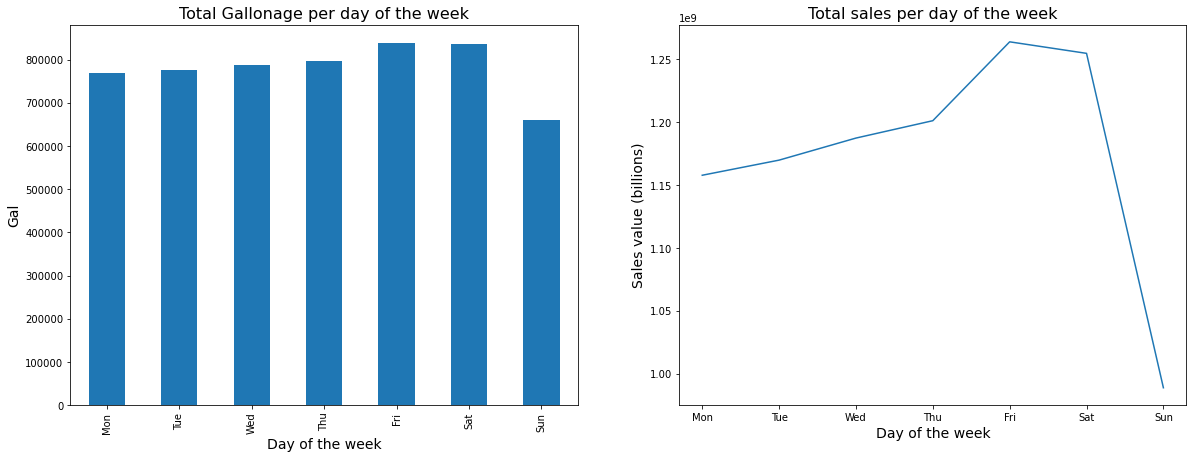

In [6]:
# Sum all the values for the same day of the week
df_dayOfWeek_Gal = df.drop(columns=['Placa', 'IdCliente', 'IdEstacion', 'Gal_Fid', 'ValorVenta']).groupby(['FechaVenta']).sum()
df_dayOfWeek_Venta = df.drop(columns=['Placa', 'IdCliente', 'IdEstacion', 'Gal_Fid', 'Gal']).groupby(['FechaVenta']).sum()

# Plot both the gal and the total sale value

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
df_dayOfWeek_Gal.plot(kind='bar', ax=ax1)
ax1.set_xticklabels(('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
ax1.set_xlabel('Day of the week', fontsize=14)
ax1.set_ylabel('Gal', fontsize=14)
ax1.set_title('Total Gallonage per day of the week', fontsize=16)
ax1.legend().set_visible(False)

df_dayOfWeek_Venta.plot(kind='line', ax=ax2)
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_xlabel('Day of the week', fontsize=14)
ax2.set_ylabel('Sales value (billions)', fontsize=14)
ax2.set_title('Total sales per day of the week', fontsize=16)
ax2.legend().set_visible(False)

plt.savefig('galSales.png')
plt.show()

df_dayOfWeek_Gal.to_csv('gal_dayOfWeek.csv')
df_dayOfWeek_Venta.to_csv('venta_dayOfWeek.csv')

Así pues, los días que más se dispensa gas natural en la compañía son los viernes y los sábados. Además, con los datos históricos proveídos, el patrón que se forma es que entre lunes y jueves hay una venta más o menos constante, viernes y sábado aumenta considerablemente, y luego se disminuyen considerablemente el domingo. Por lo tanto, se decide tomar como el valor de martes y miércoles el promedio de los días lunes a jueves.

In [7]:
# Mon-Thu sales average
ave = df_dayOfWeek_Venta.iloc[:3, 0].mean()
print(ave)

1171740863.8566668


# Datos de localización

In [8]:
# We absorb geolocation and stations data. The aim is to combine all three dataframes to give information about regional behaviour
df_geo = pd.read_excel('Geo.xlsx')
df_est = pd.read_csv('Estaciones.txt', sep='£', encoding='unicode_escape', engine='python')
display(df_geo)

,NombreDpto,IdCiudad,NombreCiudad
0,<Ninguno (Mexico)>,-4,NO DEFINIDA (MEXICO)
1,<Ninguno (Chile)>,-3,NO DEFINIDA (CHILE)
2,<Ninguno (Peru)>,-2,NO DEFINIDA (PERU)
3,<Ninguno (Venezuela)>,-1,NO DEFINIDA (VENEZUELA)
4,<Ninguno (Colombia)>,0,NO DEFINIDA (COLOMBIA)
...,...,...,...
1121,VAUPES,10952,YAVARATE
1122,VICHADA,10953,CUMARIBO
1123,VICHADA,10954,LA PRIMAVERA
1124,VICHADA,10955,PUERTO CARREÑO


In [9]:
# Remove duplicate rows
df_geo.drop_duplicates()
df_est.drop_duplicates()
# Trim leading and trailing spaces
df_geo['NombreDpto'].str.strip()
df_geo['NombreCiudad'].str.strip()
df_est['TipoEstacion'].str.strip()
# Check datatypes 
df_est.dtypes
# Parse datatypes
# Check for missing values
df_geo.info() # No missing values, but the first entries are clearly wrong
print('\n')
df_est.info() # 5 missing values in 'TipoEstacion' variable

# Eliminate irrelevant observations
df_geo.drop(index=[0, 1, 2, 3, 4 , 5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NombreDpto    1126 non-null   object
 1   IdCiudad      1126 non-null   int64 
 2   NombreCiudad  1126 non-null   object
dtypes: int64(1), object(2)
memory usage: 26.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IdEstacion    408 non-null    int64 
 1   IdCiudad      408 non-null    int64 
 2   TipoEstacion  403 non-null    object
dtypes: int64(2), object(1)
memory usage: 9.7+ KB


,NombreDpto,IdCiudad,NombreCiudad
6,ANTIOQUIA,9837,ABRIAQUI
7,ANTIOQUIA,9838,ALEJANDRIA
8,ANTIOQUIA,9839,AMAGA
9,ANTIOQUIA,9840,AMALFI
10,ANTIOQUIA,9841,ANDES
...,...,...,...
1121,VAUPES,10952,YAVARATE
1122,VICHADA,10953,CUMARIBO
1123,VICHADA,10954,LA PRIMAVERA
1124,VICHADA,10955,PUERTO CARREÑO


Para analizar el comportamiento por regional, necesitamos usar la tabla intermediaria estaciones, ya que no hay nada que conecte la ciudad con la venta. Así, la mejor herramienta es SQL, y se elige pandasql para hacer esto.

In [27]:
query = """
SELECT df_geo.NombreDpto, SUM(df.ValorVenta) AS VentaTotal
  FROM df
  JOIN df_est
    ON df.IdEstacion = df_est.IdEstacion
  JOIN df_geo
    ON df_est.IdCiudad = df_geo.IdCiudad
 GROUP BY df_geo.NombreDpto
"""

df_reg = sqldf(query)
df_reg.to_csv('regional.csv')
df_reg['Perc'] = df_reg['VentaTotal']/df_reg['VentaTotal'].sum() * 100
df_reg.sort_values(by='VentaTotal')

,NombreDpto,VentaTotal,Perc
4,BOYACA,4.469318e+07,0.543436
6,CAUCA,5.458094e+07,0.663664
7,CESAR,5.741086e+07,0.698074
12,META,6.263619e+07,0.761610
10,HUILA,8.747842e+07,1.063674
16,SUCRE,1.480657e+08,1.800370
15,SANTANDER,1.580785e+08,1.922120
17,TOLIMA,1.613187e+08,1.961518
8,CORDOBA,2.017629e+08,2.453289
9,CUNDINAMARCA,2.139027e+08,2.600901


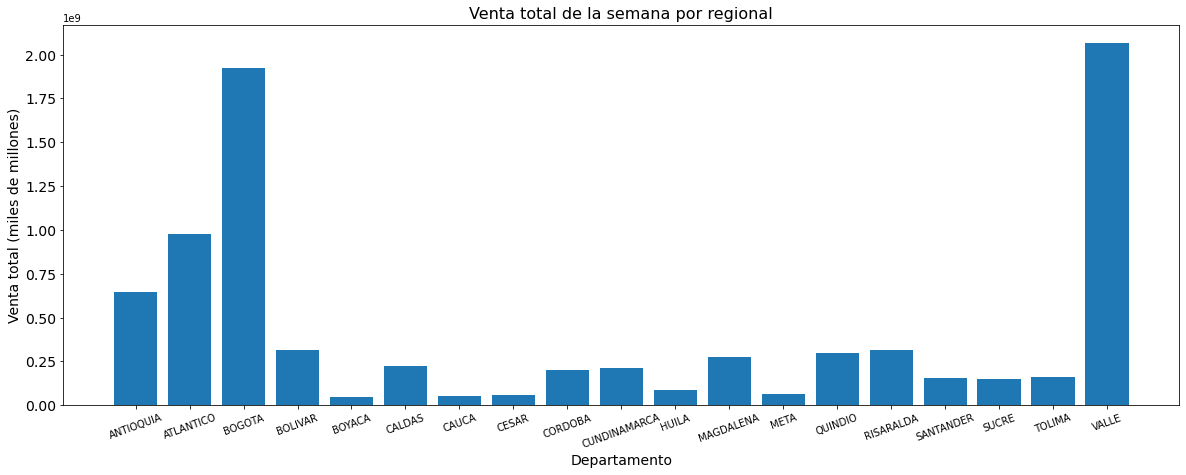

In [11]:
fig = plt.figure(figsize=(20,7))

plt.bar(x=df_reg['NombreDpto'], height=df_reg['VentaTotal'])
plt.title('Venta total de la semana por regional', fontsize=16)
plt.xlabel('Departamento', fontsize=14)
plt.ylabel('Venta total (miles de millones)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=20)
plt.savefig('regional.jpg')
plt.show()

Así pues, vemos que el departamento que más ventas produjo fue el Valle, seguido de Bogotá y el que menos, Boyacá.

Ahora analizamos el comportamiento por estación de servicio.

<Figure size 1440x504 with 0 Axes>

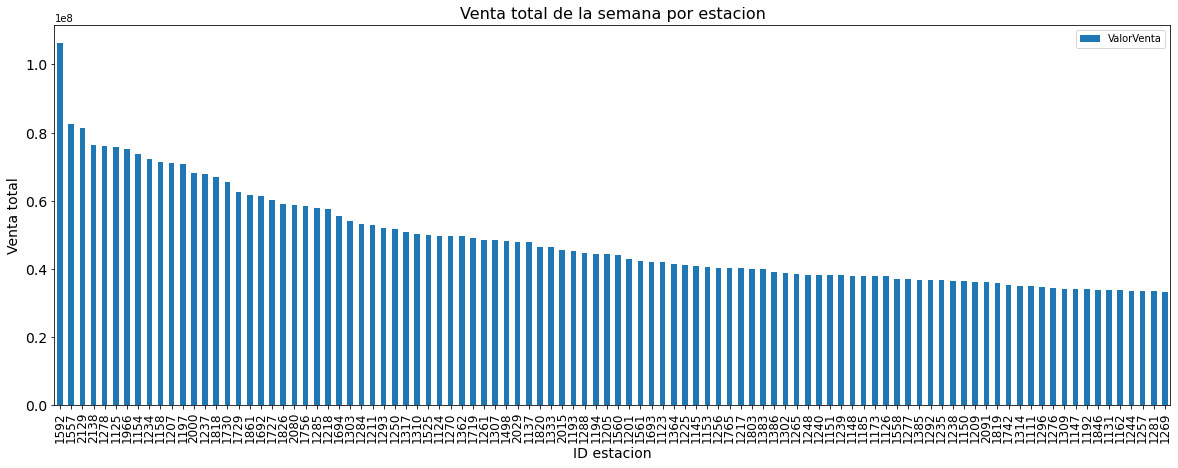

In [12]:
# Group total sales of the week by Station ID
df_porEst = df.drop(columns=['Placa', 'FechaVenta', 'IdCliente', 'Gal_Fid', 'Gal']).groupby(['IdEstacion']).sum()

# Since there are a lot of them, work only with the 100 that produced the most value
df_mostValSta = df_porEst.sort_values(by='ValorVenta', ascending=False).iloc[:100]
df_mostValSta.to_csv('stations.csv')

fig = plt.figure(figsize=(20,7))
df_mostValSta.plot(kind='bar', figsize=(20,7))
plt.xlabel('ID estacion', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Venta total', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Venta total de la semana por estacion', fontsize=16)
plt.savefig('estaciones.jpg')
plt.show()

Como podemos ver, la estación con ID 1592 produce significativamente más ventas que las demás estaciones, y la caída en venta por la semana es más o menos lineal. Esta 100 estaciones que más producen valor están ubicadas en.

In [13]:
query_sta = """
SELECT df_mostValSta.IdEstacion, df_geo.NombreCiudad
  FROM df_mostValSta
  JOIN df_est
    ON df_mostValSta.IdEstacion = df_est.IdEstacion
  JOIN df_geo
    ON df_est.IdCiudad = df_geo.IdCiudad
 ORDER BY df_mostValSta.ValorVenta DESC
 LIMIT 10
"""

df_sta = sqldf(query_sta)
df_sta

,IdEstacion,NombreCiudad
0,1592,CALI
1,1557,BOGOTÁ D.C.
2,2129,BOGOTÁ D.C.
3,2138,BOGOTÁ D.C.
4,1278,ARMENIA
5,1125,BARRANQUILLA
6,1966,BOGOTÁ D.C.
7,1154,CALI
8,1234,BOGOTÁ D.C.
9,1158,CALI


# Clientes

In [14]:
# Absorb customers data
df_cust = pd.read_excel('Customers.xlsx')
df_cust

,IdCliente,Segmento,IdCiudad,FechaNacimiento
0,1953063,SUSTENTO,10848,2016-12-27
1,1954662,SUSTENTO,10848,1963-08-12
2,1954663,SUSTENTO,10848,2017-12-01
3,1954666,SUSTENTO,9984,1986-03-21
4,1954671,SUSTENTO,10262,2017-12-01
...,...,...,...,...
801332,1894508,RECORRIDO,10675,2015-02-10
801333,1894618,RECORRIDO,10222,2015-02-10
801334,1894657,RECORRIDO,10880,1961-09-12
801335,1894757,RECORRIDO,10669,2015-03-10


In [15]:
# Remove duplicate rows
df_cust.drop_duplicates()
# Trim leading and trailing spaces
df_cust['Segmento'].str.strip()
# Check datatypes 
df_cust.dtypes
# Parse datatypes
df_cust['FechaNacimiento'] = pd.to_datetime(df_cust['FechaNacimiento']).dt.date
# Check for missing values
df_cust.info()

# Add a column to see if customer is at least 16 years old
df_cust['Driver'] = (df_cust['FechaNacimiento'] < date(2007,4,17)).map({True:'non driver', False:'driver'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801337 entries, 0 to 801336
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   IdCliente        801337 non-null  int64 
 1   Segmento         801336 non-null  object
 2   IdCiudad         801337 non-null  int64 
 3   FechaNacimiento  781629 non-null  object
dtypes: int64(2), object(2)
memory usage: 24.5+ MB


En este caso tenemos un número significativo de valores faltantes en la variable FechaNacimiento. Ya que es un número relativamente pequeño de observaciones (~2.5%) y que solo afecta esta variable, se decide no utilizar estos valores en los análisis que involucren estan variable.

Ahora se hace la segmentación por la variable "segmento". Se cuenta el número de clientes de acuerdo a su segmento.

In [16]:
df_seg = df_cust.groupby(['Segmento', 'Driver']).count()
df_seg = df_seg.reset_index()
df_seg.to_csv('segmentation.csv')
df_seg

,Segmento,Driver,IdCliente,IdCiudad,FechaNacimiento
0,NEGOCIO,driver,10,10,1
1,NEGOCIO,non driver,154,154,154
2,RECORRIDO,driver,11845,11845,9908
3,RECORRIDO,non driver,44649,44649,44649
4,SUSTENTO,driver,116507,116507,104670
5,SUSTENTO,non driver,462629,462629,462629
6,Sin Segmento,driver,5935,5935,11
7,Sin Segmento,non driver,159607,159607,159607


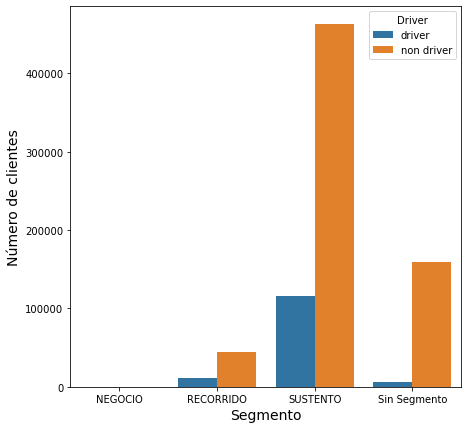

In [17]:
fig = plt.figure(figsize=(7,7))
sns.barplot(data=df_seg, x='Segmento', y='IdCliente', hue='Driver')
plt.ylabel('Número de clientes', fontsize=14)
plt.xlabel('Segmento', fontsize=14)
plt.savefig('segmentos.jpg')

Vemos que "sustento" es el segmento que mayor número de clientes tiene. Sin embargo, la mayoría de los clientes son no conductores y, por lo tanto, no son los que compran. El número real de clientes solamente son los conductores.

Ahora veamos cuales son los clientes de mayor valor para la marca.

In [18]:
# Group total sales of the week by Client ID
df_porCli = df.drop(columns=['Placa', 'FechaVenta', 'IdEstacion', 'Gal_Fid', 'Gal']).groupby(['IdCliente']).sum()
df_porCli.to_csv('clienteVal.csv')
df_porCli.sort_values(by='ValorVenta', ascending=False)

,ValorVenta
IdCliente,
-99999,1.393441e+09
1882443,1.165839e+06
1808690,8.302780e+05
566196,7.972870e+05
1945044,7.914450e+05
...,...
1780940,4.330000e+02
1949006,2.970000e+02
1671453,2.840000e+02


<Figure size 1440x720 with 0 Axes>

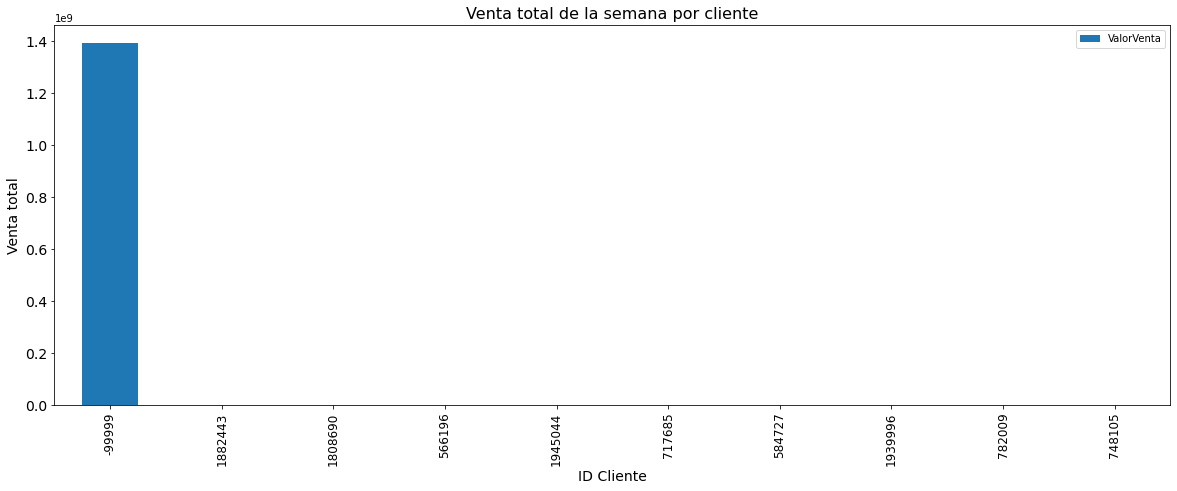

In [19]:
# Group total sales of the week by Client ID
df_porCli = df.drop(columns=['Placa', 'FechaVenta', 'IdEstacion', 'Gal_Fid', 'Gal']).groupby(['IdCliente']).sum()

# Since there are a lot of them, work only with the 100 that produced the most value
df_mostValCli = df_porCli.sort_values(by='ValorVenta', ascending=False).iloc[:10]

fig = plt.figure(figsize=(20,10))
df_mostValCli.plot(kind='bar', figsize=(20,7))
plt.xlabel('ID Cliente', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Venta total', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Venta total de la semana por cliente', fontsize=16)
plt.savefig('clientesVal.jpg')
plt.show()

Por mucho, el cliente con identificación -99999 es el de más valor. Esto es, la vasta mayoría de las ganancias de la compañía siguen viniendo de personas no afiliadas al programa de fidelización. Al no estar afiliadas, no se tienen datos de la ciudad de donde son originarias. Sin embargo, podemos tratar de evaluar la efectividad del programa al analizar el monto de las ventas de los clientes no afiliados.

In [20]:
df_noAfil = df[df['IdCliente'] == -99999]
df_noAfil.groupby('Placa').sum().sort_values(by=['ValorVenta'], ascending=False)['ValorVenta']

Placa
                   602608.0
CAQ972             573204.0
TZY438             546380.0
BET875             526749.0
IBQ032             467702.0
                     ...   
SDU216                 12.0
STM527                 11.0
SOR387                 10.0
RFZ170                  6.0
BEP050                  1.0
Name: ValorVenta, Length: 55847, dtype: float64

Cuando se compara el cliente afiliado que más compró (1.16 M) vs el no afiliado que más compró (0.57 M), así como los segundos y terceros puestos, vemos que el programa está siendo efectivo, solamente necesita expandirse.

Ahora evaluemos el auto que más gas compró durante la semana.

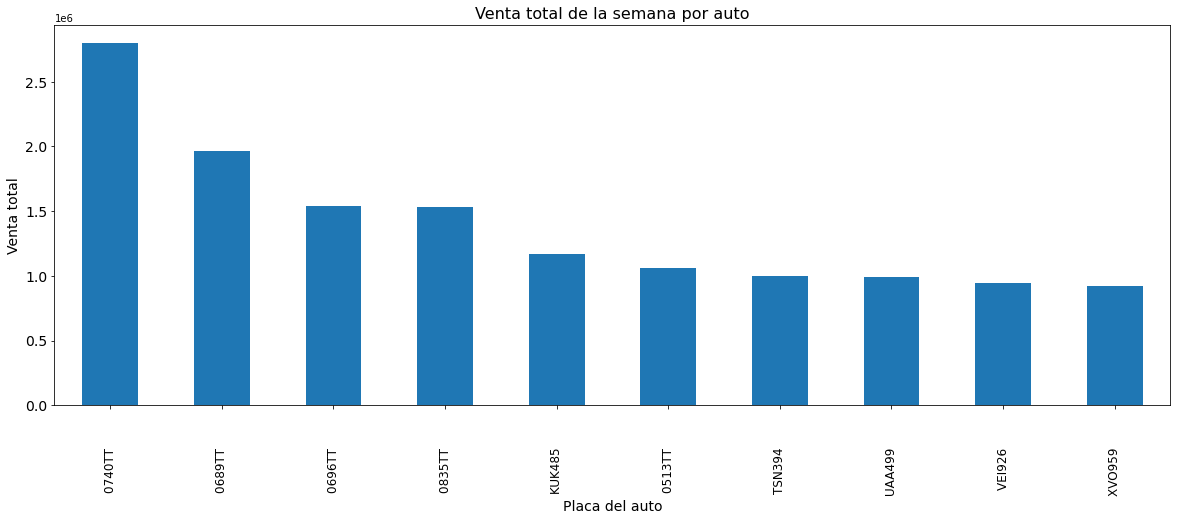

In [21]:
df_placa = df.groupby('Placa').sum().sort_values(by='ValorVenta', ascending=False).iloc[:10]

fig = plt.figure(figsize=(20,10))
df_placa['ValorVenta'].plot(kind='bar', figsize=(20,7))
plt.xlabel('Placa del auto', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Venta total', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Venta total de la semana por auto', fontsize=16)
plt.savefig('placasVal.jpg')
plt.show()

In [35]:
df_placa.reset_index()
df_placa.to_csv('placasVal.csv')
df[df['Placa'].str.contains('0740TT', na=False)][['Placa', 'IdEstacion', 'ValorVenta']].sort_values(by='ValorVenta', ascending=False)

,Placa,IdEstacion,ValorVenta
413009,0740TT,1278,37078.0
217734,0740TT,1278,35577.0
407610,0740TT,1278,35154.0
702858,0740TT,1278,34595.0
290183,0740TT,1278,33946.0
...,...,...,...
201258,0740TT,1278,3900.0
684015,0740TT,1278,3812.0
123152,0740TT,1278,3672.0
148904,0740TT,1278,3672.0


In [23]:
df_sta[df_sta['IdEstacion'] == 1278]

,IdEstacion,NombreCiudad
4,1278,ARMENIA
